# Contract Term Structure & Front/Next Logic

This notebook implements the logic to determine the term structure of contracts, identifying the "front" and "next" contracts for each instrument root and date. This enables the construction of continuous price series and the calculation of carry signals.

In [1]:
import sys
import os
import logging
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure src is in path
sys.path.append(os.path.abspath('..'))

from src.term_structure import compute_days_to_expiry, select_front_next_contracts, calculate_instrument_returns, calculate_carry_signal

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
DATA_PATH = Path("../data/processed/master_dataset_cleaned.parquet")
OUTPUT_DIR = Path("../data/processed")
OUTPUT_FILE = OUTPUT_DIR / "master_dataset_with_carry.parquet"

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Data
Load the cleaned master dataset.

In [2]:
if DATA_PATH.exists():
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded {len(df):,} rows.")
else:
    print(f"Data file not found at {DATA_PATH}")

Loaded 608,378 rows.


## 2. Compute Days to Expiry
Calculate the number of days until expiration for each contract.

In [3]:
df = compute_days_to_expiry(df)

# Filter out expired contracts (days_to_expiry <= 0)
initial_len = len(df)
df = df[df['days_to_expiry'] > 0].copy()
print(f"Dropped {initial_len - len(df):,} rows with days_to_expiry <= 0.")

# Display sample
cols = ['date', 'root', 'expiration', 'days_to_expiry']
display(df[cols].sample(5))

Dropped 1,812 rows with days_to_expiry <= 0.


,date,root,expiration,days_to_expiry
499807,2023-03-24,GC,2023-12-27 18:30:00+00:00,278
521919,2023-08-04,CL,2023-08-22 18:30:00+00:00,18
236178,2018-12-12,HO,2020-11-30 19:30:00+00:00,719
73958,2016-03-01,ZT,2016-03-31 17:01:00+00:00,30
360486,2020-12-16,ZC,2021-05-14 17:01:00+00:00,149


## 3. Select Front and Next Contracts
Identify the front and next contracts based on liquidity and time to expiry.

In [4]:
df = select_front_next_contracts(df)

# Verify selection
print("Front/Next Selection Sample:")
cols = ['date', 'root', 'instrument_id', 'days_to_expiry', 'volume', 'is_front', 'is_next']
display(df[df['root'] == 'ES'].sort_values(['date', 'days_to_expiry']).head(10)[cols])

2025-12-04 05:02:59,253 - INFO - Selecting front and next contracts...


Front/Next Selection Sample:


,date,root,instrument_id,days_to_expiry,volume,is_front,is_next
60,2015-01-01,ES,50393,78,8768,True,False
61,2015-01-01,ES,85974,169,10,False,True
62,2015-01-01,ES,58738,260,1,False,False
143,2015-01-02,ES,50393,77,1347655,True,False
142,2015-01-02,ES,85974,168,1367,False,True
141,2015-01-02,ES,58738,259,22,False,False
140,2015-01-02,ES,13950,350,12,False,False
365,2015-01-04,ES,50393,75,16891,True,False
366,2015-01-04,ES,85974,166,58,False,True
533,2015-01-05,ES,50393,74,2022311,True,False


## 4. Calculate Instrument Returns (Roll-Adjusted)
Calculate daily returns for each instrument *before* stitching to avoid roll gaps.

In [5]:
df = calculate_instrument_returns(df)
df = calculate_carry_signal(df)
print("Instrument returns and Carry signal calculated.")

2025-12-04 05:02:59,664 - INFO - Calculating instrument-level returns...


2025-12-04 05:02:59,848 - INFO - Calculating carry signal...


Instrument returns and Carry signal calculated.


## 5. Visualize Selection
Visualize the front and next contract selection for a sample root to verify the roll logic.

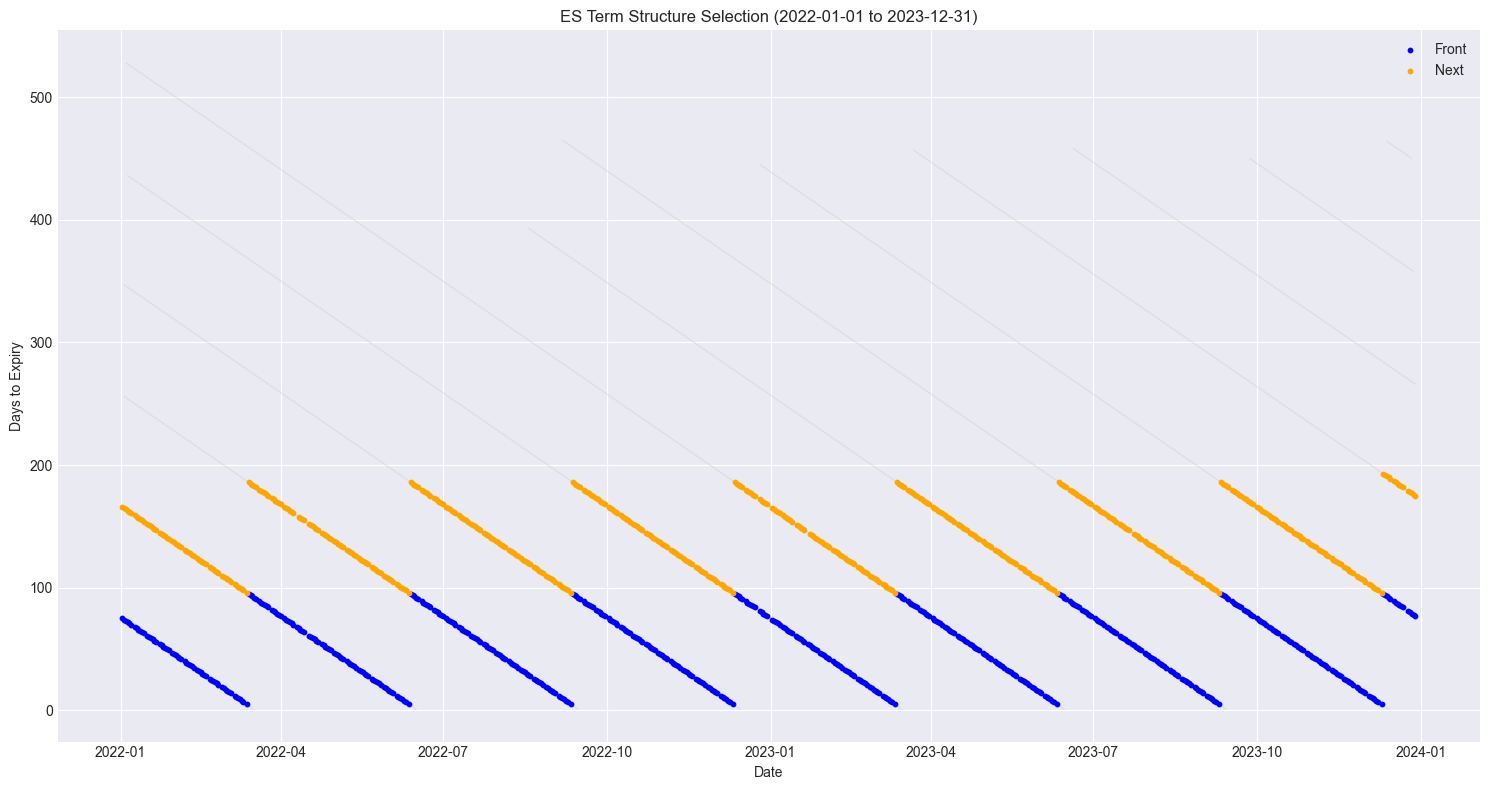

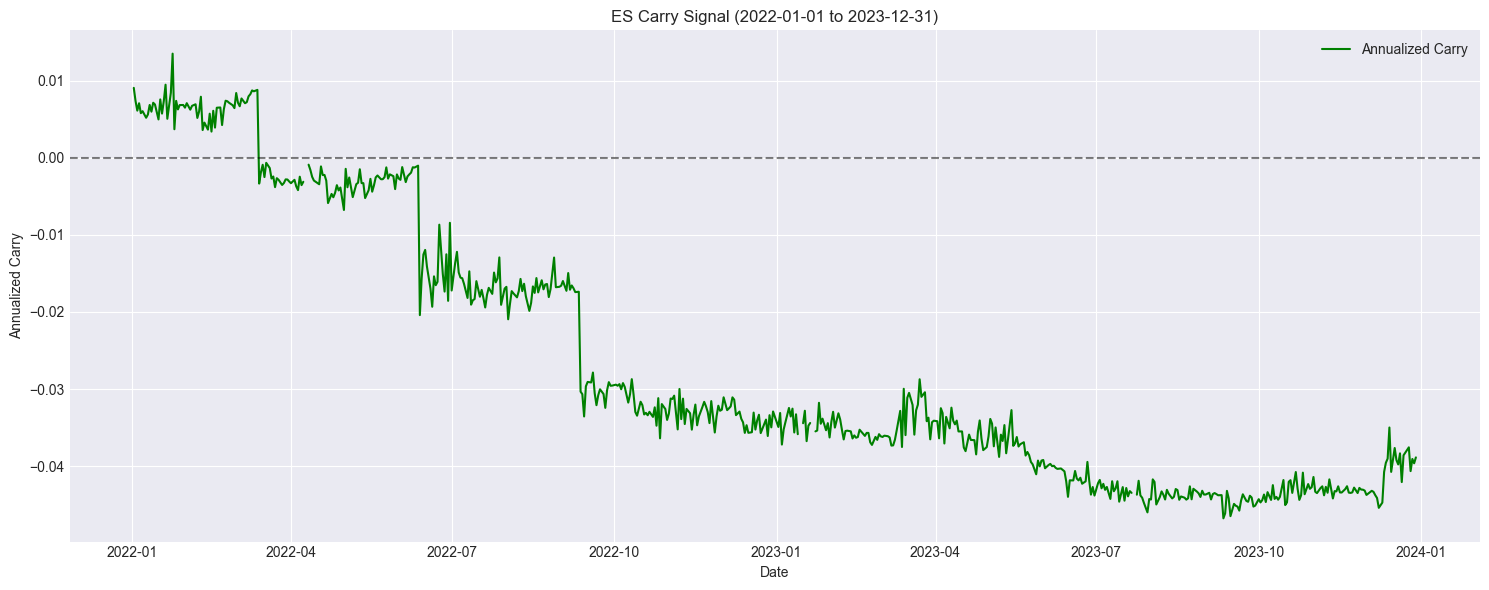

In [6]:
def plot_term_structure(df, root, start_date, end_date):
    mask = (df['root'] == root) & (df['date'] >= start_date) & (df['date'] <= end_date)
    subset = df[mask].copy()
    
    if subset.empty:
        print(f"No data for {root} between {start_date} and {end_date}")
        return

    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot all contracts as grey lines
    for inst_id, group in subset.groupby('instrument_id'):
        ax.plot(group['date'], group['days_to_expiry'], color='lightgrey', alpha=0.5, linewidth=1)
        
    # Highlight front contracts
    front = subset[subset['is_front']]
    ax.scatter(front['date'], front['days_to_expiry'], color='blue', s=10, label='Front', zorder=5)
    
    # Highlight next contracts
    next_c = subset[subset['is_next']]
    ax.scatter(next_c['date'], next_c['days_to_expiry'], color='orange', s=10, label='Next', zorder=5)
    
    ax.set_title(f'{root} Term Structure Selection ({start_date} to {end_date})')
    ax.set_ylabel('Days to Expiry')
    ax.set_xlabel('Date')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Visualize ES for a 2-year period
plot_term_structure(df, 'ES', '2022-01-01', '2023-12-31')

def plot_carry_signal(df, root, start_date, end_date):
    mask = (df['root'] == root) & (df['date'] >= start_date) & (df['date'] <= end_date)
    subset = df[mask].copy()
    
    if subset.empty:
        print(f"No data for {root} between {start_date} and {end_date}")
        return

    # Filter for front contracts to plot the signal
    front = subset[subset['is_front']].sort_values('date')
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(front['date'], front['carry'], label='Annualized Carry', color='green')
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    ax.set_title(f'{root} Carry Signal ({start_date} to {end_date})')
    ax.set_ylabel('Annualized Carry')
    ax.set_xlabel('Date')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_carry_signal(df, 'ES', '2022-01-01', '2023-12-31')

## 6. Build Continuous Front Returns
Construct the continuous front contract price series using the roll-adjusted returns.

Continuous Front Returns Sample:


root,6A,6B,6C,6E,6J,6N,6S,CL,ES,GC,...,UB,ZB,ZC,ZF,ZL,ZM,ZN,ZS,ZT,ZW
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.010938,-0.016378,-0.013963,-0.007028,-0.004672,-0.012794,-0.008939,-0.031897,-0.006192,0.001520,...,0.012512,0.009093,NaN,0.002696,NaN,NaN,0.005184,NaN,0.000500,NaN
2015-01-04,-0.002609,-0.002547,-0.001062,-0.004663,0.000361,-0.003534,-0.002405,-0.011172,-0.002810,-0.005043,...,0.001872,0.001716,NaN,0.000525,NaN,NaN,0.000737,NaN,0.000000,NaN
2015-01-05,0.003737,-0.001702,0.003071,-0.000753,0.008062,0.004598,-0.000603,-0.040980,-0.009924,0.019575,...,0.011774,0.007068,0.025237,0.000983,0.022848,0.034231,0.003313,0.037665,0.000071,0.012043
2015-01-06,-0.002234,-0.008066,-0.006831,-0.005442,0.006445,0.005885,-0.005127,-0.042532,-0.011632,0.012051,...,0.016993,0.010421,-0.003077,0.003863,-0.003366,0.007325,0.005748,0.011298,0.000715,0.006375


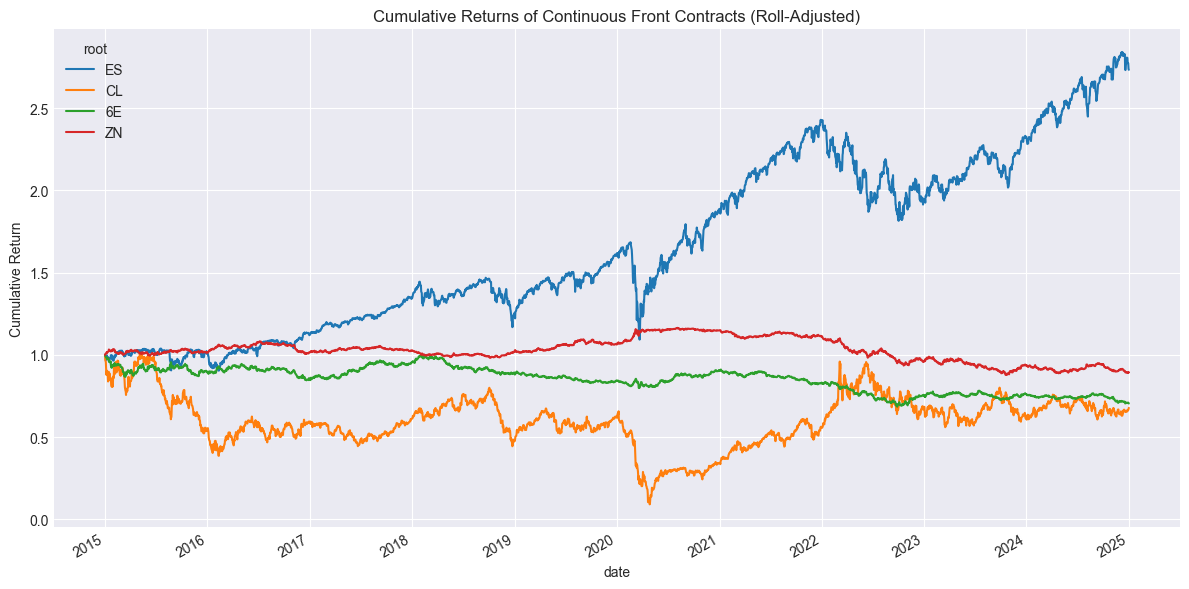

In [7]:
# Select front contract returns directly
# This avoids price jumps at roll dates
front_rets = (
    df[df['is_front']]
    .pivot(index='date', columns='root', values='return')
    .sort_index()
)

# Display sample
print("Continuous Front Returns Sample:")
display(front_rets.head())

# Visualize cumulative returns for a few assets
fig, ax = plt.subplots(figsize=(12, 6))
sample_roots = ['ES', 'CL', '6E', 'ZN']
valid_roots = [r for r in sample_roots if r in front_rets.columns]

if valid_roots:
    (1 + front_rets[valid_roots].fillna(0)).cumprod().plot(ax=ax)
    ax.set_title('Cumulative Returns of Continuous Front Contracts (Roll-Adjusted)')
    ax.set_ylabel('Cumulative Return')
    plt.tight_layout()
    plt.show()

## 7. Save Data
Save the dataframe with term structure flags and calculated returns.

In [8]:
if not df.empty:
    try:
        df.to_parquet(OUTPUT_FILE, index=False)
        print(f"Successfully saved {len(df):,} rows to {OUTPUT_FILE}")
    except Exception as e:
        print(f"Error saving data: {e}")

Successfully saved 606,566 rows to ../data/processed/master_dataset_with_carry.parquet


## 6. Visualize Carry Signal
Plot the annualized carry signal for a sample instrument to verify the calculation.

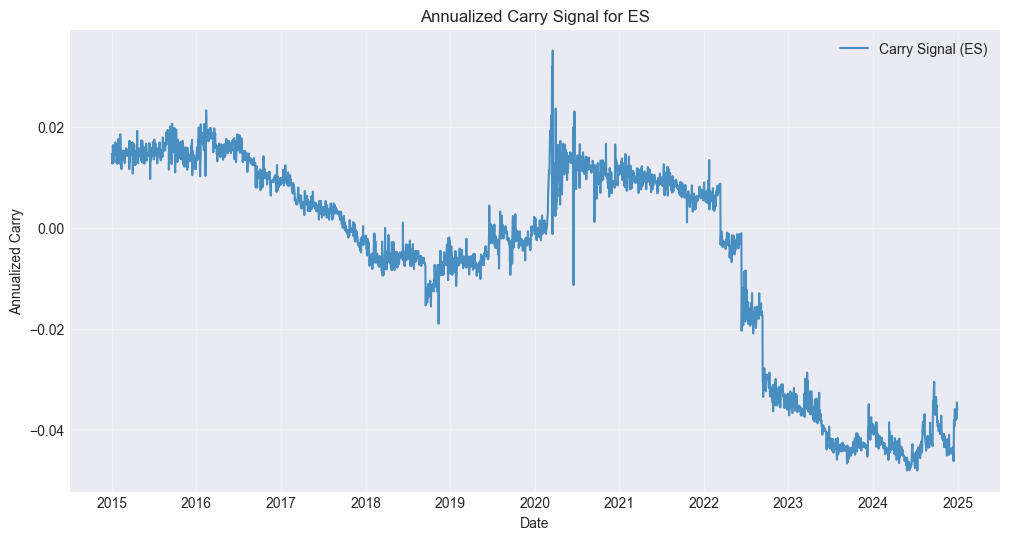

In [9]:
sample_root = 'ES'
# Drop duplicates to handle the case where carry is broadcasted to multiple contracts per date
carry_data = df[df['root'] == sample_root].drop_duplicates('date').set_index('date')['carry'].dropna().sort_index()

if not carry_data.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(carry_data.index, carry_data.values, label=f'Carry Signal ({sample_root})', alpha=0.8)
    plt.title(f'Annualized Carry Signal for {sample_root}')
    plt.ylabel('Annualized Carry')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"No carry data found for {sample_root}")